In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pykitti
import os
from pathlib import Path
from matplotlib import pyplot as plt
from src.vo import VO

In [2]:
def extract_features(frame):
    global orb
    if orb is None:
        orb = cv2.ORB_create()
    return cv2.goodFeaturesToTrack(frame,256,0.01,10)

In [8]:
def show_features(frame, features):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    
    for i in features:
        x,y = i.pt
        cv2.circle(frame_rgb,(int(x),int(y)),5,255,-1)
    
    return frame_rgb

def show_deltas(vo, max_distance=None):
    frame_rgb = cv2.cvtColor(vo.frames[-1], cv2.COLOR_GRAY2RGB)
    
    for match in vo.matches[-1]:
        if max_distance is not None and match.dist > max_distance:
            continue
        
        p1 = vo.keypoints[-1][match.trainIdx].pt
        p2 = vo.keypoints[-2][match.queryIdx].pt
        cv2.line(frame_rgb, 
                 (int(p1[0]), int(p1[1])), 
                 (int(p2[0]), int(p2[1])),
                 (255,0,0),1)
        
    return frame_rgb

In [4]:
root = Path('sample')
drive = '00'

seq_path = root / 'data_odometry_gray' / 'dataset' / drive / 'image_0'
frames = sorted(os.listdir(seq_path))
vo = VO()

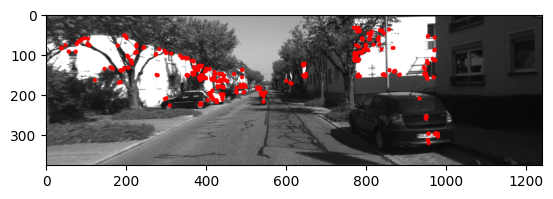

In [5]:


vo.append(cv2.imread(str(seq_path / frames[0]), cv2.IMREAD_UNCHANGED))
vo.append(cv2.imread(str(seq_path / frames[1]), cv2.IMREAD_UNCHANGED))

plt.imshow(show_features(vo.frames[-1], vo.keypoints[-1]))
plt.show()

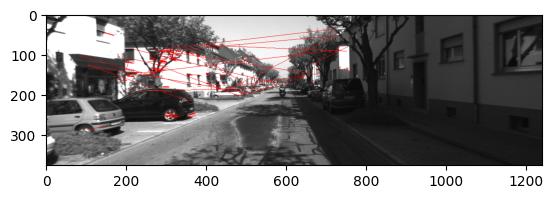

In [9]:
plt.imshow(show_deltas(vo))
plt.show()

In [10]:
vo.reset()
title = "displacement vectors"
cv2.namedWindow(title)

for frame in frames:
    I = cv2.imread(str(seq_path / frame), cv2.IMREAD_UNCHANGED)
    vo.append(I)
    
    if len(vo.frames) >= 2:
        cv2.imshow(title, show_deltas(vo, max_distance=20))
        cv2.waitKey()
        
cv2.destroyWindow(title)

AttributeError: 'cv2.DMatch' object has no attribute 'dist'